# Sales Data Analysis and Revenue Forecasting Using  Big Data tools



## Fetching data from API and inserting it to MONGODB

In [ ]:
import requests
from pymongo import MongoClient


client = MongoClient("mongodb://localhost:27017/")
db = client["SalesDatabase"]
collection = db["SalesRecords"]


api_url = "http://127.0.0.1:5000/data"


page = 1
while True:
    response = requests.get(f"{api_url}?page={page}&page_size=1000")
    data = response.json()
    records = data["data"]
    
    if not records:
        break  

    collection.insert_many(records)
    print(f"Inserted {len(records)} records from page {page}")
    
    page += 1


# Bronze Layer

## Count Rows and Columns in MongoDB Collection

In [4]:
row_count = collection.count_documents({})
print(f"Number of Rows: {row_count}")


Number of Rows: 100000


In [6]:
sample_doc = collection.find_one()
column_count = len(sample_doc.keys())
print(f"Number of Columns: {column_count}")


Number of Columns: 15


## Loading Data into Pandas Dataframe


In [8]:
from pymongo import MongoClient
import pandas as pd

client = MongoClient("mongodb://localhost:27017/")
db = client["SalesDatabase"]
collection = db["SalesRecords"]

data = pd.DataFrame(list(collection.find()))

if "_id" in data.columns:
    data.drop("_id", axis=1, inplace=True)


# Silver Layer


## Handling the null values in the database


In [10]:

print(data.isnull().sum())

data.fillna("Unknown", inplace=True)  


Country           0
Item Type         0
Order Date        0
Order ID          0
Order Priority    0
Region            0
Sales Channel     0
Ship Date         0
Total Cost        0
Total Profit      0
Total Revenue     0
Unit Cost         0
Unit Price        0
Units Sold        0
dtype: int64


## connects to a MongoDB database, retrieves data from a specified collection

In [16]:
from pymongo import MongoClient
import pandas as pd

client = MongoClient("mongodb://localhost:27017/")
db = client["SalesDatabase"]
collection = db["SalesRecords"]

data = pd.DataFrame(list(collection.find()))


if "_id" in data.columns:
    data.drop("_id", axis=1, inplace=True)

print(data.head())


                 Country      Item Type Order Date   Order ID Order Priority  \
0             Azerbaijan         Snacks  10/8/2014  535113847              C   
1                 Panama      Cosmetics  2/22/2015  874708545              L   
2  Sao Tome and Principe         Fruits  12/9/2015  854349935              M   
3  Sao Tome and Principe  Personal Care  9/17/2014  892836844              M   
4                 Belize      Household   2/4/2010  129280602              H   

                              Region Sales Channel   Ship Date  Total Cost  \
0       Middle East and North Africa        Online  10/23/2014    91008.96   
1  Central America and the Caribbean       Offline   2/27/2015  1198414.83   
2                 Sub-Saharan Africa       Offline   1/18/2016    69103.12   
3                 Sub-Saharan Africa        Online  10/12/2014   516717.06   
4  Central America and the Caribbean       Offline    3/5/2010  2943879.32   

   Total Profit  Total Revenue  Unit Cost  Unit Pr

# GOLD LAYER


## Creating Aggregation and saving the results in csv & Mongodb

In [33]:
import pandas as pd
from pymongo import MongoClient

# Connect to MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["SalesDatabase"]
collection = db["SalesRecords"]

# Load cleaned data from MongoDB
data = pd.DataFrame(list(collection.find()))

# Drop MongoDB's default _id field if present
if "_id" in data.columns:
    data.drop("_id", axis=1, inplace=True)

# Convert Order Date to datetime
data["Order Date"] = pd.to_datetime(data["Order Date"], errors="coerce")

# Extract month from Order Date
data["month"] = data["Order Date"].dt.to_period("M")

# Aggregation 1: Total Sales by Region
region_summary = data.groupby("Region").agg(
    total_units_sold=("Units Sold", "sum"),
    total_revenue=("Total Revenue", "sum")
).reset_index()
print("Total Sales by Region:")
print(region_summary)

# Aggregation 2: Top 5 Products by Revenue
top_products = data.groupby("Item Type").agg(
    total_revenue=("Total Revenue", "sum"),
    total_units_sold=("Units Sold", "sum")
).sort_values("total_revenue", ascending=False).head(5)
print("\nTop 5 Products by Revenue:")
print(top_products)

# Aggregation 3: Monthly Revenue Trends
monthly_trends = data.groupby("month").agg(
    total_revenue=("Total Revenue", "sum"),
    total_orders=("Order ID", "count")
).reset_index()
print("\nMonthly Revenue Trends:")
print(monthly_trends)


# Aggregation 4: Revenue and Units Sold by Country
country_summary = data.groupby(["Region", "Country"]).agg(
    total_units_sold=("Units Sold", "sum"),
    total_revenue=("Total Revenue", "sum")
).reset_index()
print("\nRevenue and Units Sold by Country:")
print(country_summary)

# Save results to CSV
region_summary.to_csv("region_summary.csv", index=False)
top_products.to_csv("top_products.csv", index=False)
monthly_trends.to_csv("monthly_trends.csv", index=False)
country_summary.to_csv("country_summary.csv", index=False)

# Save results back to MongoDB
db["RegionSummary"].insert_many(region_summary.to_dict("records"))
db["TopProducts"].insert_many(top_products.to_dict("records"))
db["MonthlyTrends"].insert_many(monthly_trends.to_dict("records"))
db["CountrySummary"].insert_many(country_summary.to_dict("records"))


Total Sales by Region:
                              Region  total_units_sold  total_revenue
0                               Asia          72822259   1.929340e+10
1              Australia and Oceania          40797618   1.070152e+10
2  Central America and the Caribbean          53871798   1.455373e+10
3                             Europe         128664731   3.424115e+10
4       Middle East and North Africa          63251625   1.692141e+10
5                      North America          10845905   2.937002e+09
6                 Sub-Saharan Africa         129890681   3.495845e+10

Top 5 Products by Revenue:
                 total_revenue  total_units_sold
Item Type                                       
Household         2.770567e+10          41458795
Office Supplies   2.754184e+10          42293330
Cosmetics         1.832938e+10          41924464
Meat              1.761195e+10          41745367
Baby Food         1.069920e+10          41911620

Monthly Revenue Trends:
      month  total_re

InvalidDocument: cannot encode object: Period('2010-01', 'M'), of type: <class 'pandas._libs.tslibs.period.Period'>

# Visualization 1

## Total Revenue by Region

Matplotlib is building the font cache; this may take a moment.


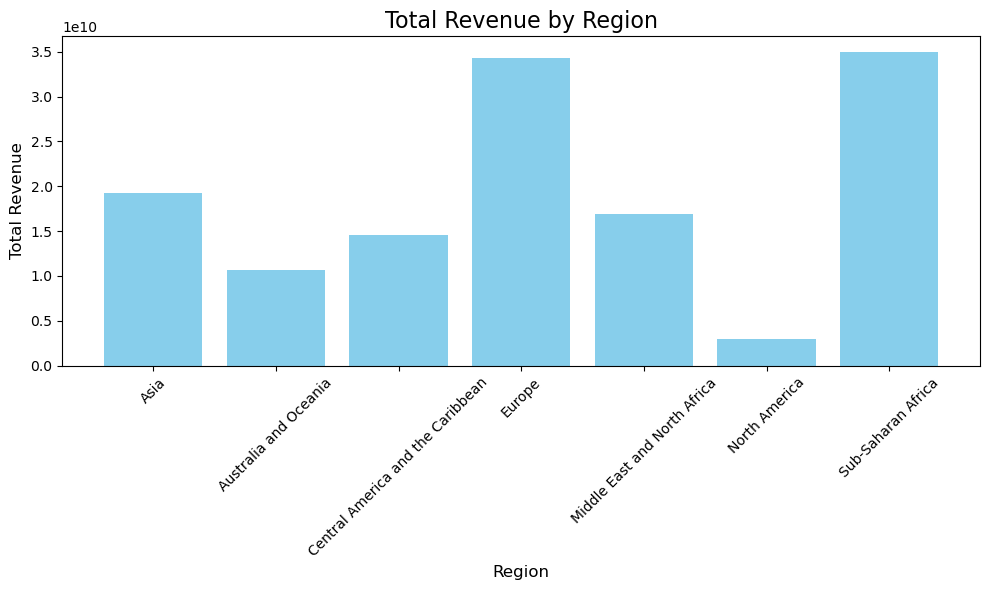

In [35]:
import matplotlib.pyplot as plt

# Plot total revenue by region
plt.figure(figsize=(10, 6))
plt.bar(region_summary["Region"], region_summary["total_revenue"], color="skyblue")
plt.title("Total Revenue by Region", fontsize=16)
plt.xlabel("Region", fontsize=12)
plt.ylabel("Total Revenue", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("total_revenue_by_region.png")  # Save the visualization
plt.show()


# Visualization 2

## Monthly Revenue Trends

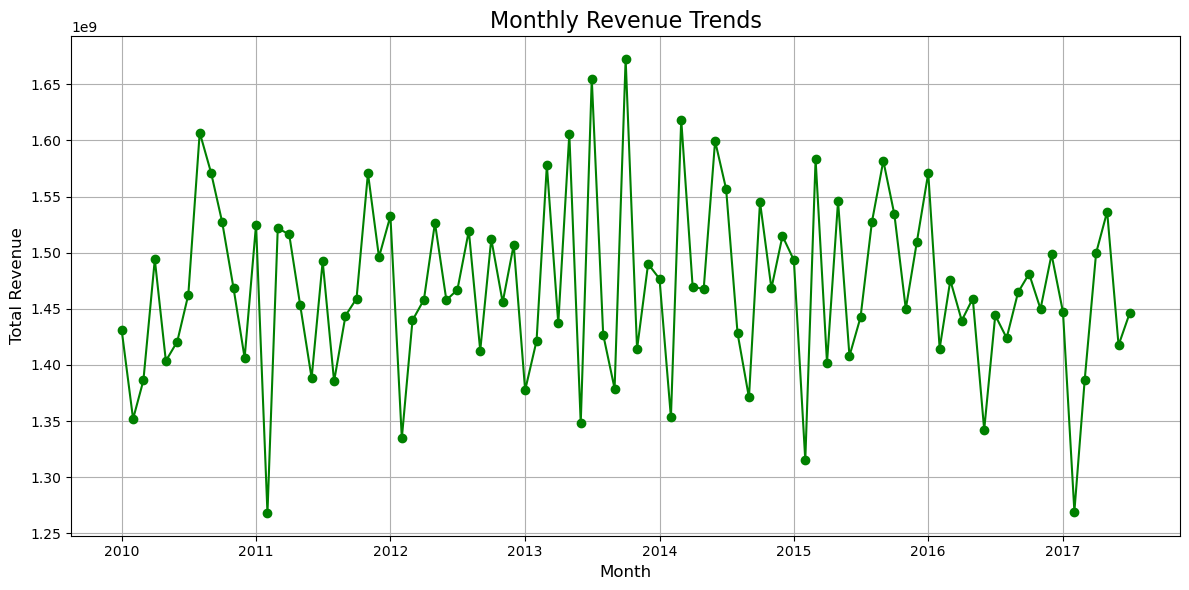

In [41]:
# Convert 'month' to datetime for proper plotting
monthly_trends["month"] = monthly_trends["month"].dt.to_timestamp()

# Plot monthly revenue trends
plt.figure(figsize=(12, 6))
plt.plot(monthly_trends["month"], monthly_trends["total_revenue"], marker="o", linestyle="-", color="green")
plt.title("Monthly Revenue Trends", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Total Revenue", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig("monthly_revenue_trends.png")  # Save the visualization
plt.show()


# Visualization 3

## Total Revenue by item type and Region

<Figure size 1200x600 with 0 Axes>

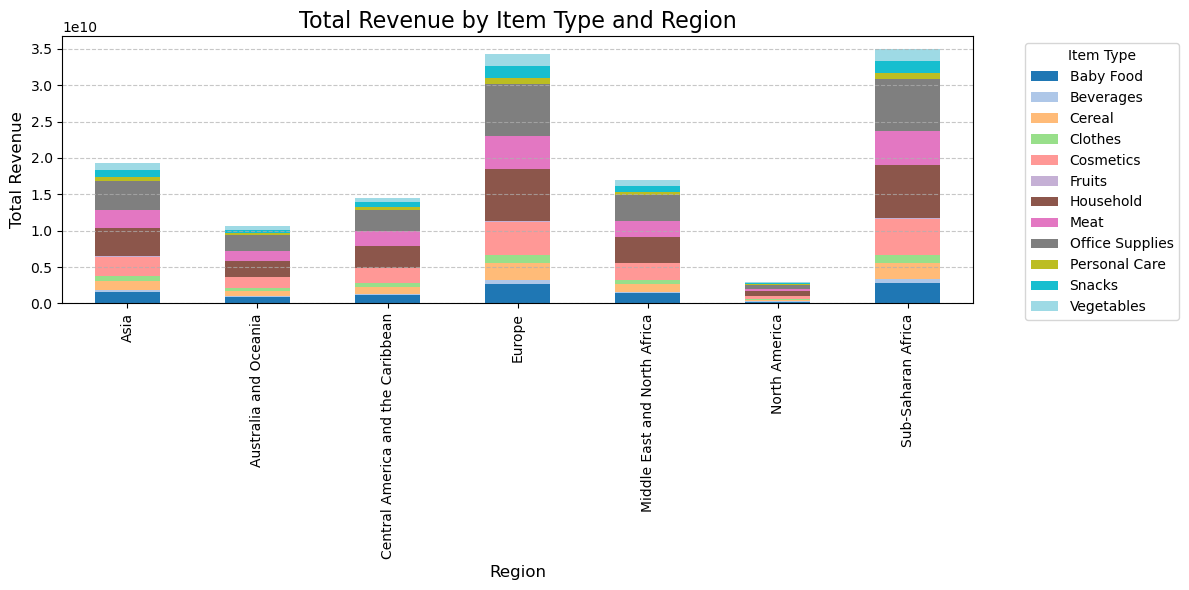

In [63]:
import matplotlib.pyplot as plt
import pandas as pd

# Group data by Region and Item Type to calculate total revenue
grouped_data = data.groupby(["Region", "Item Type"])["Total Revenue"].sum().unstack()

# Plot a stacked bar chart
plt.figure(figsize=(12, 6))
grouped_data.plot(kind="bar", stacked=True, colormap="tab20", figsize=(12, 6))

# Add titles and labels
plt.title("Total Revenue by Item Type and Region", fontsize=16)
plt.xlabel("Region", fontsize=12)
plt.ylabel("Total Revenue", fontsize=12)
plt.legend(title="Item Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

# Save the visualization
plt.savefig("total_revenue_item_type_region.png")
plt.show()
